In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check column names of the inventory dataframe
print(inventory_df.columns)


Index(['CFG', 'ITM_DESC', 'CHANNEL_ID', 'PRODUCT_ID', 'PRODUCT_NAME',
       'SCHEDULER_NAME', 'DMND_WEEK_STRT_DATE', 'VRSN_WEEK_STRT_DATE',
       'MRP_FCST_QTY', 'SUPPLY_CHAIN_TYPE', 'Unnamed: 10', 'LEAD_TIME'],
      dtype='object')


In [ ]:
import pandas as pd

# Load data from CSV files
sales_forecast_df = pd.read_csv('SFC.csv')
inventory_df = pd.read_csv('Inventory.csv')
orders_df = pd.read_csv('Orders.csv')

# Convert relevant columns to numeric, handling errors
sales_forecast_df['FORCASTED_SALES'] = pd.to_numeric(sales_forecast_df['FORCASTED_SALES'], errors='coerce')
inventory_df['MRP_FCST_QTY'] = pd.to_numeric(inventory_df['MRP_FCST_QTY'], errors='coerce')
orders_df['QUANTITY'] = pd.to_numeric(orders_df['QUANTITY'], errors='coerce')

# Function to calculate average sales per item
def calculate_average_sales(sales_forecast_df):
    return sales_forecast_df['FORCASTED_SALES'].mean()

# Step 1: Review the sales forecast
average_sales = calculate_average_sales(sales_forecast_df)

# Filter products that have sales below or equal to average
selected_items_df = sales_forecast_df[sales_forecast_df['FORCASTED_SALES'] <= average_sales]

# Step 2: Check the total inventory
# Merge inventory with selected items
inventory_check_df = pd.merge(selected_items_df[['PRODUCT_ID', 'PRODUCT_NAME']], inventory_df, on='PRODUCT_ID', how='left')

# Step 3: Deduct inventory from order quantity
# Merge orders with inventory to calculate how much more needs to be produced
order_inventory_df = pd.merge(orders_df[['PRODUCT_ID', 'PRODUCT_NAME', 'QUANTITY']], inventory_df[['PRODUCT_ID', 'PRODUCT_NAME', 'MRP_FCST_QTY']], on='PRODUCT_ID', how='left')
order_inventory_df['remaining_quantity'] = order_inventory_df['QUANTITY'] - order_inventory_df['MRP_FCST_QTY'].fillna(0)
order_inventory_df['remaining_quantity'] = order_inventory_df['remaining_quantity'].clip(lower=0)  # No negative quantities

# Step 4: Identify critical-to-sale items (with 0 inventory)
critical_items_df = order_inventory_df[order_inventory_df['MRP_FCST_QTY'].fillna(0) == 0]

# Step 5: Plan production for critical-to-sale items
# Assume production capacity and lines are constants
production_lines = 3
daily_capacity_per_line = 1000
total_daily_capacity = production_lines * daily_capacity_per_line

# Calculate days needed for critical-to-sale items
critical_items_df['days_to_produce'] = (critical_items_df['remaining_quantity'] / total_daily_capacity).apply(lambda x: round(x))

# Step 6: Plan production for remaining items
remaining_items_df = order_inventory_df[order_inventory_df['MRP_FCST_QTY'].fillna(0) > 0]
remaining_items_df['days_to_produce'] = (remaining_items_df['remaining_quantity'] / total_daily_capacity).apply(lambda x: round(x))

# Step 7: Create a final production plan
rolling_plan_df = pd.concat([critical_items_df, remaining_items_df])

# Sort by critical-to-sale items first and then by remaining days to produce
rolling_plan_df = rolling_plan_df.sort_values(by=['MRP_FCST_QTY', 'days_to_produce'])

# Final rolling plan output
print("Rolling Plan:")
print(rolling_plan_df[['PRODUCT_ID', 'remaining_quantity', 'days_to_produce']])

# Save rolling plan to a CSV
rolling_plan_df[['PRODUCT_ID', 'remaining_quantity', 'days_to_produce']].to_csv('rolling_plan.csv', index=False)


Rolling Plan:
    PRODUCT_ID  remaining_quantity  days_to_produce
0        55725                62.0              0.0
1        55725                62.0              0.0
2        55725                62.0              0.0
3        55725                62.0              0.0
4        60147               126.0              0.0
5        60147               126.0              0.0
6        60147               126.0              0.0
7        60147               126.0              0.0
8        60147               126.0              0.0
9        60147               126.0              0.0
10       59515               268.0              0.0
11       59515               268.0              0.0
12       57455               312.0              0.0
13       59515               115.0              0.0
14       59515               115.0              0.0
15       53291               286.0              0.0
16       63395               270.0              0.0
17         199                95.0              0.

In [ ]:
import pandas as pd
from datetime import datetime, timedelta

# Load data from CSV files
orders_df = pd.read_csv('Orders.csv')
inventory_df = pd.read_csv('Inventory.csv')

# Convert relevant columns to numeric and dates
orders_df['QUANTITY'] = pd.to_numeric(orders_df['QUANTITY'], errors='coerce')
inventory_df['LEAD_TIME'] = pd.to_numeric(inventory_df['LEAD_TIME'], errors='coerce')
orders_df['ORDER_DATE'] = pd.to_datetime(orders_df['ORDER_DATE'], errors='coerce')

# Check for missing or invalid dates and fill with a default date
if orders_df['ORDER_DATE'].isnull().any():
    print("Warning: Some orders have missing or invalid order dates. Filling with a default date.")
    orders_df['ORDER_DATE'].fillna(pd.Timestamp('2024-01-01'), inplace=True)  # Filling with a default date

# Check for missing lead times and fill with a default value
if inventory_df['LEAD_TIME'].isnull().any():
    print("Warning: Some products have missing lead times. Filling with a default lead time of 0 days.")
    inventory_df['LEAD_TIME'].fillna(0, inplace=True)  # Filling with a default lead time

# Constants
daily_production_minutes = 1152  # 80% of 24 hours in minutes
minutes_per_battery = 20  # 20 minutes lead time per battery

# Function to calculate the production schedule
def calculate_production_schedule(order_quantity, order_date, lead_time_days):
    total_production_minutes = order_quantity * minutes_per_battery
    days_needed = total_production_minutes // daily_production_minutes
    remaining_minutes = total_production_minutes % daily_production_minutes

    # Schedule production for the required days
    production_schedule = []
    current_date = order_date

    # Handle full days of production
    for day in range(int(days_needed)):
        production_schedule.append({
            'Production Date': current_date.strftime('%Y-%m-%d') if not pd.isnull(current_date) else 'Unknown',
            'Minutes Used': daily_production_minutes
        })
        current_date += timedelta(days=1)

    # Handle remaining production on the last day
    if remaining_minutes > 0:
        production_schedule.append({
            'Production Date': current_date.strftime('%Y-%m-%d') if not pd.isnull(current_date) else 'Unknown',
            'Minutes Used': remaining_minutes
        })

    # Calculate Lead Time Completion Date
    lead_time_completion_date = order_date + timedelta(days=lead_time_days) if not pd.isnull(order_date) else 'Unknown'

    return production_schedule, lead_time_completion_date

# Step 1: Merge orders with inventory to get lead time for each product
order_inventory_df = pd.merge(orders_df, inventory_df[['PRODUCT_ID', 'LEAD_TIME']], on='PRODUCT_ID', how='left')

# Step 2: Apply production scheduling for each order
final_schedule = []
for index, row in order_inventory_df.iterrows():
    order_quantity = row['QUANTITY']
    order_date = row['ORDER_DATE']
    lead_time_days = row['LEAD_TIME']

    # Calculate production schedule based on order quantity, order date, and lead time
    schedule, lead_time_completion_date = calculate_production_schedule(order_quantity, order_date, lead_time_days)

    # Append the results with order and item details
    for entry in schedule:
        final_schedule.append({
            'Order No': row['ORDER_ID'],
            'Item Code': row['PRODUCT_ID'],
            'Item Description': row['PRODUCT_NAME'],
            'Order Quantity': row['QUANTITY'],
            'Lead Time (days)': lead_time_days,
            'Lead Time Completion Date': lead_time_completion_date if isinstance(lead_time_completion_date, str) else lead_time_completion_date.strftime('%Y-%m-%d'),
            'Production Date': entry['Production Date'],
            'Minutes Used': entry['Minutes Used']
        })

# Convert final schedule to DataFrame for easier visualization
final_schedule_df = pd.DataFrame(final_schedule)

# Display the final production schedule
print(final_schedule_df)

# Save the production schedule to CSV
final_schedule_df.to_csv('production_schedule.csv', index=False)


       Order No  Item Code  Item Description  Order Quantity  \
0    FW1MN55725      55725     CEDAR15HSWBTX              62   
1    FW1MN55725      55725     CEDAR15HSWBTX              62   
2    FW1MN55725      55725     CEDAR15HSWBTX              62   
3    FW1MN55725      55725     CEDAR15HSWBTX              62   
4    FW1MN55725      55725     CEDAR15HSWBTX              62   
..          ...        ...               ...             ...   
97   MC34Y62907      62907  BEAVERCREEK14BTX             271   
98   MC34Y62907      62907  BEAVERCREEK14BTX             271   
99   MC34Y62907      62907  BEAVERCREEK14BTX             271   
100  MC34Y62907      62907  BEAVERCREEK14BTX             271   
101  MC34Y62907      62907  BEAVERCREEK14BTX             271   

     Lead Time (days) Lead Time Completion Date Production Date  Minutes Used  
0                 0.0                2016-05-02      2016-05-02          1152  
1                 0.0                2016-05-02      2016-05-03        

In [ ]:
  import pandas as pd
  from datetime import datetime, timedelta

  # Load data from CSV files
  orders_df = pd.read_csv('Orders.csv')
  inventory_df = pd.read_csv('Inventory.csv')

  # Convert relevant columns to numeric and dates
  orders_df['QUANTITY'] = pd.to_numeric(orders_df['QUANTITY'], errors='coerce')
  inventory_df['LEAD_TIME'] = pd.to_numeric(inventory_df['LEAD_TIME'], errors='coerce')
  orders_df['ORDER_DATE'] = pd.to_datetime(orders_df['ORDER_DATE'], errors='coerce')

  # Check for missing or invalid dates and fill with a default date
  if orders_df['ORDER_DATE'].isnull().any():
      print("Warning: Some orders have missing or invalid order dates. Filling with a default date.")
      orders_df['ORDER_DATE'].fillna(pd.Timestamp('2024-01-01'), inplace=True)  # Filling with a default date

  # Check for missing lead times and fill with a default value
  if inventory_df['LEAD_TIME'].isnull().any():
      print("Warning: Some products have missing lead times. Filling with a default lead time of 0 days.")
      inventory_df['LEAD_TIME'].fillna(0, inplace=True)  # Filling with a default lead time

  # Constants
  daily_production_minutes = 1152  # 80% of 24 hours in minutes
  minutes_per_battery = 20  # 20 minutes lead time per battery

  # Function to calculate the production schedule
  def calculate_production_schedule(order_quantity, order_date, lead_time_days):
      total_production_minutes = order_quantity * minutes_per_battery
      days_needed = total_production_minutes // daily_production_minutes
      remaining_minutes = total_production_minutes % daily_production_minutes

      # Schedule production for the required days
      production_schedule = []
      current_date = order_date

      # Handle full days of production
      for day in range(int(days_needed)):
          production_schedule.append({
              'Production Date': current_date.strftime('%Y-%m-%d') if not pd.isnull(current_date) else 'Unknown',
              'Minutes Used': daily_production_minutes
          })
          current_date += timedelta(days=1)

      # Handle remaining production on the last day
      if remaining_minutes > 0:
          production_schedule.append({
              'Production Date': current_date.strftime('%Y-%m-%d') if not pd.isnull(current_date) else 'Unknown',
              'Minutes Used': remaining_minutes
          })

      # Calculate Lead Time Completion Date
      lead_time_completion_date = order_date + timedelta(days=lead_time_days) if not pd.isnull(order_date) else 'Unknown'

      return production_schedule, lead_time_completion_date

  # Step 1: Merge orders with inventory to get lead time for each product
  order_inventory_df = pd.merge(orders_df, inventory_df[['PRODUCT_ID', 'LEAD_TIME']], on='PRODUCT_ID', how='left')

  # Step 2: Apply production scheduling for each order
  final_schedule = []
  for index, row in order_inventory_df.iterrows():
      order_quantity = row['QUANTITY']
      order_date = row['ORDER_DATE']
      lead_time_days = row['LEAD_TIME']

      # Calculate production schedule based on order quantity, order date, and lead time
      schedule, lead_time_completion_date = calculate_production_schedule(order_quantity, order_date, lead_time_days)

      # Append the results with order and item details
      for entry in schedule:
          final_schedule.append({
              'Order No': row['ORDER_ID'],
              'Item Code': row['PRODUCT_ID'],
              'Item Description': row['PRODUCT_NAME'],
              'Order Quantity': row['QUANTITY'],
              'Lead Time (days)': lead_time_days,
              'Lead Time Completion Date': lead_time_completion_date if isinstance(lead_time_completion_date, str) else lead_time_completion_date.strftime('%Y-%m-%d'),
              'Production Date': entry['Production Date'],
              'Minutes Used': entry['Minutes Used']
          })

  # Convert final schedule to DataFrame for easier visualization
  final_schedule_df = pd.DataFrame(final_schedule)

  # Display the final production schedule in a tabular form
  print(final_schedule_df.to_string(index=False))  # Remove index for cleaner output

  # Save the production schedule to CSV
  final_schedule_df.to_csv('production_schedule.csv', index=False)


  Order No  Item Code Item Description  Order Quantity  Lead Time (days) Lead Time Completion Date Production Date  Minutes Used
FW1MN55725      55725    CEDAR15HSWBTX              62               0.0                2016-05-02      2016-05-02          1152
FW1MN55725      55725    CEDAR15HSWBTX              62               0.0                2016-05-02      2016-05-03            88
FW1MN55725      55725    CEDAR15HSWBTX              62               0.0                2016-05-02      2016-05-02          1152
FW1MN55725      55725    CEDAR15HSWBTX              62               0.0                2016-05-02      2016-05-03            88
FW1MN55725      55725    CEDAR15HSWBTX              62               0.0                2016-05-02      2016-05-02          1152
FW1MN55725      55725    CEDAR15HSWBTX              62               0.0                2016-05-02      2016-05-03            88
FW1MN55725      55725    CEDAR15HSWBTX              62               0.0                2016-05-0

<ipython-input-1-197fa02b2ea1>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  orders_df['ORDER_DATE'].fillna(pd.Timestamp('2024-01-01'), inplace=True)  # Filling with a default date
<ipython-input-1-197fa02b2ea1>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, whe

  Order No  Item Code Item Description  Order Quantity  Lead Time (days) Lead Time Completion Date Production Date  Minutes Used
FW1MN55725      55725    CEDAR15HSWBTX              62               0.0                2016-05-02      2016-05-02          1152
FW1MN55725      55725    CEDAR15HSWBTX              62               0.0                2016-05-02      2016-05-03            88
FW1MN55725      55725    CEDAR15HSWBTX              62               0.0                2016-05-02      2016-05-02          1152
FW1MN55725      55725    CEDAR15HSWBTX              62               0.0                2016-05-02      2016-05-03            88
FW1MN55725      55725    CEDAR15HSWBTX              62               0.0                2016-05-02      2016-05-02          1152
FW1MN55725      55725    CEDAR15HSWBTX              62               0.0                2016-05-02      2016-05-03            88
FW1MN55725      55725    CEDAR15HSWBTX              62               0.0                2016-05-0

<ipython-input-10-2cff44d16492>:121: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sales_forecast_df['DATE'] = pd.to_datetime(sales_forecast_df['DATE'], errors='coerce')


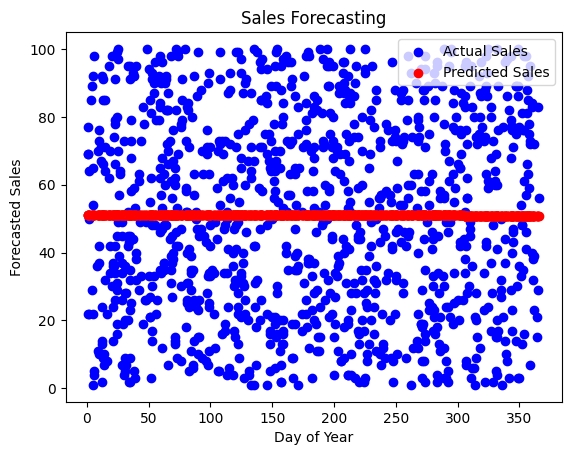

Optimal Inventory Levels: {'product_1': 100, 'product_2': 100}
Detected Anomalies in Sales Data:
      PRODUCT_ID  FORCASTED_SALES
1          60147                3
24         60147                2
40         63886              100
48         66803                1
71         64248                1
...          ...              ...
5444       66803                1
5447       59860               96
5449       84467                1
5460       73756              100
5465       66947               98

[547 rows x 2 columns]


In [ ]:
import pandas as pd
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load data from CSV files
orders_df = pd.read_csv('Orders.csv')
inventory_df = pd.read_csv('Inventory.csv')

# Convert relevant columns to numeric and dates
orders_df['QUANTITY'] = pd.to_numeric(orders_df['QUANTITY'], errors='coerce')
inventory_df['LEAD_TIME'] = pd.to_numeric(inventory_df['LEAD_TIME'], errors='coerce')
orders_df['ORDER_DATE'] = pd.to_datetime(orders_df['ORDER_DATE'], errors='coerce')

# Check for missing or invalid dates and fill with a default date
if orders_df['ORDER_DATE'].isnull().any():
    print("Warning: Some orders have missing or invalid order dates. Filling with a default date.")
    orders_df['ORDER_DATE'].fillna(pd.Timestamp('2024-01-01'), inplace=True)  # Filling with a default date

# Check for missing lead times and fill with a default value
if inventory_df['LEAD_TIME'].isnull().any():
    print("Warning: Some products have missing lead times. Filling with a default lead time of 0 days.")
    inventory_df['LEAD_TIME'].fillna(0, inplace=True)  # Filling with a default lead time

# Constants
daily_production_minutes = 1152  # 80% of 24 hours in minutes
minutes_per_battery = 20  # 20 minutes lead time per battery

# Function to calculate the production schedule
def calculate_production_schedule(order_quantity, order_date, lead_time_days):
    total_production_minutes = order_quantity * minutes_per_battery
    days_needed = total_production_minutes // daily_production_minutes
    remaining_minutes = total_production_minutes % daily_production_minutes

    # Schedule production for the required days
    production_schedule = []
    current_date = order_date

    # Handle full days of production
    for day in range(int(days_needed)):
        production_schedule.append({
            'Production Date': current_date.strftime('%Y-%m-%d') if not pd.isnull(current_date) else 'Unknown',
            'Minutes Used': daily_production_minutes
        })
        current_date += timedelta(days=1)

    # Handle remaining production on the last day
    if remaining_minutes > 0:
        production_schedule.append({
            'Production Date': current_date.strftime('%Y-%m-%d') if not pd.isnull(current_date) else 'Unknown',
            'Minutes Used': remaining_minutes
        })

    # Calculate Lead Time Completion Date
    lead_time_completion_date = order_date + timedelta(days=lead_time_days) if not pd.isnull(order_date) else 'Unknown'

    return production_schedule, lead_time_completion_date

# Step 1: Merge orders with inventory to get lead time for each product
order_inventory_df = pd.merge(orders_df, inventory_df[['PRODUCT_ID', 'LEAD_TIME']], on='PRODUCT_ID', how='left')

# Step 2: Apply production scheduling for each order
final_schedule = []
for index, row in order_inventory_df.iterrows():
    order_quantity = row['QUANTITY']
    order_date = row['ORDER_DATE']
    lead_time_days = row['LEAD_TIME']

    # Calculate production schedule based on order quantity, order date, and lead time
    schedule, lead_time_completion_date = calculate_production_schedule(order_quantity, order_date, lead_time_days)

    # Append the results with order and item details
    for entry in schedule:
        final_schedule.append({
            'Order No': row['ORDER_ID'],
            'Item Code': row['PRODUCT_ID'],
            'Item Description': row['PRODUCT_NAME'],
            'Order Quantity': row['QUANTITY'],
            'Lead Time (days)': lead_time_days,
            'Lead Time Completion Date': lead_time_completion_date if isinstance(lead_time_completion_date, str) else lead_time_completion_date.strftime('%Y-%m-%d'),
            'Production Date': entry['Production Date'],
            'Minutes Used': entry['Minutes Used']
        })

# Convert final schedule to DataFrame for easier visualization
final_schedule_df = pd.DataFrame(final_schedule)

# Display the final production schedule in a tabular form
print(final_schedule_df.to_string(index=False))  # Remove index for cleaner output

# Save the production schedule to CSV
final_schedule_df.to_csv('production_schedule.csv', index=False)

# Sales Forecasting
def sales_forecasting(sales_data):
    sales_data['DAY_OF_YEAR'] = sales_data['DATE'].dt.dayofyear
    X = sales_data[['DAY_OF_YEAR']]
    y = sales_data['FORCASTED_SALES']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error for Sales Forecasting: {mse}')

    # Plot results
    plt.scatter(X_test, y_test, color='blue', label='Actual Sales')
    plt.scatter(X_test, y_pred, color='red', label='Predicted Sales')
    plt.title('Sales Forecasting')
    plt.xlabel('Day of Year')
    plt.ylabel('Forecasted Sales')
    plt.legend()
    plt.show()

# Load Sales Forecast data and perform forecasting
sales_forecast_df = pd.read_csv('SFC.csv')
sales_forecast_df['DATE'] = pd.to_datetime(sales_forecast_df['DATE'], errors='coerce')
sales_forecasting(sales_forecast_df)

# Inventory Optimization (Simple Heuristic)
def optimize_inventory(current_inventory, predicted_sales):
    optimal_inventory = {}

    for product_id, sales in predicted_sales.items():
        if product_id in current_inventory:
            optimal_inventory[product_id] = max(0, sales - current_inventory[product_id])

    return optimal_inventory

# Example usage of inventory optimization
current_inventory = {
    'product_1': 500,
    'product_2': 300,
}
predicted_sales = {
    'product_1': 600,
    'product_2': 400,
}
optimal_inventory = optimize_inventory(current_inventory, predicted_sales)
print("Optimal Inventory Levels:", optimal_inventory)

# Anomaly Detection (Optional)
from sklearn.ensemble import IsolationForest

def detect_anomalies(sales_data):
    model = IsolationForest(contamination=0.1)
    sales_data['Anomaly'] = model.fit_predict(sales_data[['FORCASTED_SALES']])
    return sales_data[sales_data['Anomaly'] == -1]  # Return anomalies

# Detect anomalies in sales data
anomalies = detect_anomalies(sales_forecast_df)
print("Detected Anomalies in Sales Data:")
print(anomalies[['PRODUCT_ID', 'FORCASTED_SALES']])


In [ ]:
import pandas as pd
from datetime import datetime, timedelta

# Load data from CSV files
orders_df = pd.read_csv('Orders.csv')
inventory_df = pd.read_csv('Inventory.csv')

# Convert relevant columns to numeric and dates
orders_df['QUANTITY'] = pd.to_numeric(orders_df['QUANTITY'], errors='coerce')
inventory_df['LEAD_TIME'] = pd.to_numeric(inventory_df['LEAD_TIME'], errors='coerce')
orders_df['ORDER_DATE'] = pd.to_datetime(orders_df['ORDER_DATE'], errors='coerce')

# Check for missing or invalid dates and fill with a default date
if orders_df['ORDER_DATE'].isnull().any():
    print("Warning: Some orders have missing or invalid order dates. Filling with a default date.")
    orders_df['ORDER_DATE'].fillna(pd.Timestamp('2024-01-01'), inplace=True)  # Filling with a default date

# Check for missing lead times and fill with a default value
if inventory_df['LEAD_TIME'].isnull().any():
    print("Warning: Some products have missing lead times. Filling with a default lead time of 0 days.")
    inventory_df['LEAD_TIME'].fillna(0, inplace=True)  # Filling with a default lead time

# Constants
daily_production_capacity_per_line = 100  # Each line produces 100 items per day
number_of_lines = 3
total_daily_production_capacity = daily_production_capacity_per_line * number_of_lines  # Total capacity for 3 lines
minutes_per_battery = 20  # 20 minutes lead time per battery

# Function to calculate the production schedule
def calculate_production_schedule(order_quantity, order_date, lead_time_days):
    total_production_minutes = order_quantity * minutes_per_battery
    days_needed = total_production_minutes // (total_daily_production_capacity * minutes_per_battery)
    remaining_items = order_quantity % total_daily_production_capacity

    # Schedule production for the required days
    production_schedule = []
    current_date = order_date

    # Handle full days of production
    for day in range(int(days_needed)):
        production_schedule.append({
            'Production Date': current_date.strftime('%Y-%m-%d') if not pd.isnull(current_date) else 'Unknown',
            'Quantity Line 1': daily_production_capacity_per_line,
            'Quantity Line 2': daily_production_capacity_per_line,
            'Quantity Line 3': daily_production_capacity_per_line,
            'Minutes Used': total_daily_production_capacity * minutes_per_battery
        })
        current_date += timedelta(days=1)

    # Handle remaining production on the last day if needed
    if remaining_items > 0:
        quantity_per_line = [0] * number_of_lines  # Initialize a list to hold quantities for each line
        for i in range(remaining_items):
            quantity_per_line[i % number_of_lines] += 1  # Distribute remaining items across the lines

        production_schedule.append({
            'Production Date': current_date.strftime('%Y-%m-%d') if not pd.isnull(current_date) else 'Unknown',
            'Quantity Line 1': quantity_per_line[0],
            'Quantity Line 2': quantity_per_line[1],
            'Quantity Line 3': quantity_per_line[2],
            'Minutes Used': remaining_items * minutes_per_battery
        })

    # Calculate Lead Time Completion Date
    lead_time_completion_date = order_date + timedelta(days=lead_time_days) if not pd.isnull(order_date) else 'Unknown'

    return production_schedule, lead_time_completion_date

# Step 1: Merge orders with inventory to get lead time for each product
order_inventory_df = pd.merge(orders_df, inventory_df[['PRODUCT_ID', 'LEAD_TIME']], on='PRODUCT_ID', how='left')

# Step 2: Apply production scheduling for each order
final_schedule = []
for index, row in order_inventory_df.iterrows():
    order_quantity = row['QUANTITY']
    order_date = row['ORDER_DATE']
    lead_time_days = row['LEAD_TIME']

    # Calculate production schedule based on order quantity, order date, and lead time
    schedule, lead_time_completion_date = calculate_production_schedule(order_quantity, order_date, lead_time_days)

    # Append the results with order and item details
    for entry in schedule:
        final_schedule.append({
            'Order No': row['ORDER_ID'],
            'Item Code': row['PRODUCT_ID'],
            'Item Description': row['PRODUCT_NAME'],
            'Order Quantity': row['QUANTITY'],
            'Lead Time (days)': lead_time_days,
            'Lead Time Completion Date': lead_time_completion_date if isinstance(lead_time_completion_date, str) else lead_time_completion_date.strftime('%Y-%m-%d'),
            'Production Date': entry['Production Date'],
            'Quantity Line 1': entry.get('Quantity Line 1', 0),
            'Quantity Line 2': entry.get('Quantity Line 2', 0),
            'Quantity Line 3': entry.get('Quantity Line 3', 0),
            'Minutes Used': entry['Minutes Used']
        })

# Convert final schedule to DataFrame for easier visualization
final_schedule_df = pd.DataFrame(final_schedule)

# Display the final production schedule in a tabular form
print(final_schedule_df.to_string(index=False))  # Remove index for cleaner output

# Save the production schedule to CSV
final_schedule_df.to_csv('production_schedule.csv', index=False)


  Order No  Item Code Item Description  Order Quantity  Lead Time (days) Lead Time Completion Date Production Date  Quantity Line 1  Quantity Line 2  Quantity Line 3  Minutes Used
FW1MN55725      55725    CEDAR15HSWBTX              62               0.0                2016-05-02      2016-05-02               21               21               20          1240
FW1MN55725      55725    CEDAR15HSWBTX              62               0.0                2016-05-02      2016-05-02               21               21               20          1240
FW1MN55725      55725    CEDAR15HSWBTX              62               0.0                2016-05-02      2016-05-02               21               21               20          1240
FW1MN55725      55725    CEDAR15HSWBTX              62               0.0                2016-05-02      2016-05-02               21               21               20          1240
VN3N060147      60147    TULIP15BDWBTX             126               0.0                2017-04-07  

To predict the production date and lead time using machine learning, we'll first need to set up a framework where we can use historical production data to train a model. The process will involve the following steps:

Steps:
Prepare the Dataset: Historical data containing features like order quantity, product type, previous lead times, production capacity, etc., will be used as input.

Feature Engineering: We'll create features such as Order Quantity, Product Type, Lead Time (in days), and others that are important for predicting the production date and lead time.

Model Selection: We'll choose machine learning models like:

Linear Regression: For predicting numerical values like lead time.
Decision Trees or Random Forest: These models can be useful for learning non-linear relationships in the data.
Training: Train the models on the historical data.

Prediction: Use the trained model to predict the lead time and production date for new orders.

Step 1: Prepare the Dataset
We'll use the same dataset (Orders, Inventory, Sales Forecast) and create the necessary features.

Step 2: Feature Engineering
Features we can use:

Order Quantity
Product Type (categorical data, one-hot encoded)
Historical Lead Time
Production Capacity (Lines and Minutes per Battery)
Order Date (processed as day, month, year)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from datetime import timedelta

# Load data (replace with your actual CSV files)
orders_df = pd.read_csv('Orders.csv')
inventory_df = pd.read_csv('Inventory.csv')

# Convert relevant columns to numeric and datetime
orders_df['QUANTITY'] = pd.to_numeric(orders_df['QUANTITY'], errors='coerce')
orders_df['ORDER_DATE'] = pd.to_datetime(orders_df['ORDER_DATE'], errors='coerce')
inventory_df['LEAD_TIME'] = pd.to_numeric(inventory_df['LEAD_TIME'], errors='coerce')

# Handle missing order dates by filling with a specific placeholder (e.g., today's date)
orders_df['ORDER_DATE'].fillna(pd.Timestamp.today(), inplace=True)

# Merge datasets to create a unified dataset for training
merged_df = pd.merge(orders_df, inventory_df[['PRODUCT_ID', 'LEAD_TIME']], on='PRODUCT_ID', how='left')

# Feature Engineering: Extract year, month, and day from ORDER_DATE
merged_df['Order Year'] = merged_df['ORDER_DATE'].dt.year
merged_df['Order Month'] = merged_df['ORDER_DATE'].dt.month
merged_df['Order Day'] = merged_df['ORDER_DATE'].dt.day

# Handle missing values: Fill any remaining missing numeric values with 0
merged_df.fillna(0, inplace=True)

# **Check for any remaining non-numeric columns**
print("Data Types Before Encoding:")
print(merged_df.dtypes)

# Encode categorical columns (Product ID and Product Name) using OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_products = pd.DataFrame(encoder.fit_transform(merged_df[['PRODUCT_ID']]))
encoded_products.columns = encoder.get_feature_names_out(['PRODUCT_ID'])

# Concatenate the encoded product data with the main DataFrame
merged_df = pd.concat([merged_df, encoded_products], axis=1)

# Drop the original non-numeric columns (Product ID, Product Name, ORDER_DATE, ORDER_ID, CUSTOMER_ID)
merged_df.drop(['PRODUCT_ID', 'PRODUCT_NAME', 'ORDER_DATE', 'ORDER_ID', 'CUSTOMER_ID'], axis=1, inplace=True)

# Check again to ensure all features are numeric
print("Data Types After Encoding and Dropping Non-Numeric Columns:")
print(merged_df.dtypes)

# Split the dataset into features (X) and target variable (y)
X = merged_df.drop(['LEAD_TIME'], axis=1)  # Features
y = merged_df['LEAD_TIME']  # Target (Lead Time)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model (Random Forest Regressor)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model using Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE) on Test Data: {mae}")

# Predict production lead time for new data (for illustration, using the first few rows of X_test)
new_order_data = X_test.iloc[0:5]  # Example data, replace with real input
predicted_lead_times = model.predict(new_order_data)
print("Predicted Lead Times for New Orders:")
print(predicted_lead_times)

# Add the predicted lead time to the new order data
new_order_data['Predicted Lead Time (days)'] = predicted_lead_times

# Add production dates based on lead time predictions
new_order_data['Predicted Production Date'] = (
    pd.to_datetime(new_order_data['Order Year'].astype(str) + '-' +
                   new_order_data['Order Month'].astype(str) + '-' +
                   new_order_data['Order Day'].astype(str))
    + pd.to_timedelta(new_order_data['Predicted Lead Time (days)'], unit='D')
)

# Display the results with predicted production dates
print(new_order_data[['Order Year', 'Order Month', 'Order Day', 'Predicted Lead Time (days)', 'Predicted Production Date']])


Data Types Before Encoding:
ORDER_ID                object
PRODUCT_ID               int64
PRODUCT_NAME            object
QUANTITY                 int64
ORDER_DATE      datetime64[ns]
CUSTOMER_ID             object
TOTAL COST               int64
LEAD_TIME              float64
Order Year               int32
Order Month              int32
Order Day                int32
dtype: object
Data Types After Encoding and Dropping Non-Numeric Columns:
QUANTITY              int64
TOTAL COST            int64
LEAD_TIME           float64
Order Year            int32
Order Month           int32
Order Day             int32
PRODUCT_ID_199      float64
PRODUCT_ID_53291    float64
PRODUCT_ID_55725    float64
PRODUCT_ID_57455    float64
PRODUCT_ID_59515    float64
PRODUCT_ID_60147    float64
PRODUCT_ID_62907    float64
PRODUCT_ID_63395    float64
PRODUCT_ID_81734    float64
dtype: object
Mean Absolute Error (MAE) on Test Data: 0.0
Predicted Lead Times for New Orders:
[0. 0. 0. 0. 0.]
    Order Year  Order Mon

<ipython-input-20-a6e350544097>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_order_data['Predicted Lead Time (days)'] = predicted_lead_times
<ipython-input-20-a6e350544097>:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_order_data['Predicted Production Date'] = (


In [ ]:
import pandas as pd
from datetime import datetime, timedelta
from google.colab import files
from IPython.display import display, HTML

# Upload CSV files
print("Please upload the Orders.csv and Inventory.csv files.")
uploaded = files.upload()  # Users upload both files here

# Load data into DataFrames
orders_df = pd.read_csv('Orders.csv')
inventory_df = pd.read_csv('Inventory.csv')

# Data Cleaning and Type Conversion
orders_df['QUANTITY'] = pd.to_numeric(orders_df['QUANTITY'], errors='coerce')
inventory_df['LEAD_TIME'] = pd.to_numeric(inventory_df['LEAD_TIME'], errors='coerce')
orders_df['ORDER_DATE'] = pd.to_datetime(orders_df['ORDER_DATE'], errors='coerce')

# Fill missing dates with a default date
if orders_df['ORDER_DATE'].isnull().any():
    print("Warning: Some orders have missing order dates. Filling with '2024-01-01'.")
    orders_df['ORDER_DATE'].fillna(pd.Timestamp('2024-01-01'), inplace=True)

# Fill missing lead times with 0 days
if inventory_df['LEAD_TIME'].isnull().any():
    print("Warning: Some products have missing lead times. Filling with 0.")
    inventory_df['LEAD_TIME'].fillna(0, inplace=True)

# Constants
daily_production_minutes = 1152  # 80% of 24 hours in minutes
minutes_per_battery = 20

# Function to calculate production schedule
def calculate_production_schedule(order_quantity, order_date, lead_time_days):
    total_production_minutes = order_quantity * minutes_per_battery
    days_needed = total_production_minutes // daily_production_minutes
    remaining_minutes = total_production_minutes % daily_production_minutes

    production_schedule = []
    current_date = order_date

    # Full days of production
    for _ in range(int(days_needed)):
        production_schedule.append({
            'Production Date': current_date.strftime('%Y-%m-%d'),
            'Minutes Used': daily_production_minutes
        })
        current_date += timedelta(days=1)

    # Remaining minutes on the last day
    if remaining_minutes > 0:
        production_schedule.append({
            'Production Date': current_date.strftime('%Y-%m-%d'),
            'Minutes Used': remaining_minutes
        })

    lead_time_completion_date = order_date + timedelta(days=lead_time_days)
    return production_schedule, lead_time_completion_date

# Merge orders with inventory data
order_inventory_df = pd.merge(orders_df, inventory_df[['PRODUCT_ID', 'LEAD_TIME']],
                              on='PRODUCT_ID', how='left')

# Apply production scheduling for each order
final_schedule = []
for _, row in order_inventory_df.iterrows():
    order_quantity = row['QUANTITY']
    order_date = row['ORDER_DATE']
    lead_time_days = row['LEAD_TIME']

    schedule, lead_time_completion_date = calculate_production_schedule(
        order_quantity, order_date, lead_time_days
    )

    for entry in schedule:
        final_schedule.append({
            'Order No': row['ORDER_ID'],
            'Item Code': row['PRODUCT_ID'],
            'Item Description': row['PRODUCT_NAME'],
            'Order Quantity': order_quantity,
            'Lead Time (days)': lead_time_days,
            'Lead Time Completion Date': lead_time_completion_date.strftime('%Y-%m-%d'),
            'Production Date': entry['Production Date'],
            'Minutes Used': entry['Minutes Used']
        })

# Convert to DataFrame and display
final_schedule_df = pd.DataFrame(final_schedule)
display(HTML(final_schedule_df.to_html(index=False)))

# Save the production schedule to CSV
final_schedule_df.to_csv('production_schedule.csv', index=False)

# Provide download link for the generated CSV
print("Download the production schedule:")
files.download('production_schedule.csv')


Please upload the Orders.csv and Inventory.csv files.


Saving Orders.csv to Orders (1).csv


<ipython-input-2-da02498fb8b6>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  orders_df['ORDER_DATE'].fillna(pd.Timestamp('2024-01-01'), inplace=True)
<ipython-input-2-da02498fb8b6>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

Order No,Item Code,Item Description,Order Quantity,Lead Time (days),Lead Time Completion Date,Production Date,Minutes Used
FW1MN55725,55725,CEDAR15HSWBTX,62,0.0,2016-05-02,2016-05-02,1152
FW1MN55725,55725,CEDAR15HSWBTX,62,0.0,2016-05-02,2016-05-03,88
FW1MN55725,55725,CEDAR15HSWBTX,62,0.0,2016-05-02,2016-05-02,1152
FW1MN55725,55725,CEDAR15HSWBTX,62,0.0,2016-05-02,2016-05-03,88
FW1MN55725,55725,CEDAR15HSWBTX,62,0.0,2016-05-02,2016-05-02,1152
FW1MN55725,55725,CEDAR15HSWBTX,62,0.0,2016-05-02,2016-05-03,88
FW1MN55725,55725,CEDAR15HSWBTX,62,0.0,2016-05-02,2016-05-02,1152
FW1MN55725,55725,CEDAR15HSWBTX,62,0.0,2016-05-02,2016-05-03,88
VN3N060147,60147,TULIP15BDWBTX,126,0.0,2017-04-07,2017-04-07,1152
VN3N060147,60147,TULIP15BDWBTX,126,0.0,2017-04-07,2017-04-08,1152


Download the production schedule:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install flask-ngrok

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
from flask import Flask, request, render_template, send_file
from flask_ngrok import run_with_ngrok  # For running Flask via ngrok on Colab
from io import BytesIO

# Initialize Flask App
app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok for public URL

# Constants
daily_production_minutes = 1152  # 80% of 24 hours in minutes
minutes_per_battery = 20  # 20 minutes lead time per battery

# Function to calculate the production schedule
def calculate_production_schedule(order_quantity, order_date, lead_time_days):
    total_production_minutes = order_quantity * minutes_per_battery
    days_needed = total_production_minutes // daily_production_minutes
    remaining_minutes = total_production_minutes % daily_production_minutes

    production_schedule = []
    current_date = order_date

    # Full days of production
    for _ in range(int(days_needed)):
        production_schedule.append({
            'Production Date': current_date.strftime('%Y-%m-%d'),
            'Minutes Used': daily_production_minutes
        })
        current_date += timedelta(days=1)

    # Remaining minutes on the last day
    if remaining_minutes > 0:
        production_schedule.append({
            'Production Date': current_date.strftime('%Y-%m-%d'),
            'Minutes Used': remaining_minutes
        })

    lead_time_completion_date = order_date + timedelta(days=lead_time_days)
    return production_schedule, lead_time_completion_date

# Route to render the upload form
@app.route('/')
def upload_form():
    return '''
    <h2>Upload Orders and Inventory CSV Files</h2>
    <form action="/upload" method="post" enctype="multipart/form-data">
        <input type="file" name="orders_file" required><br><br>
        <input type="file" name="inventory_file" required><br><br>
        <button type="submit">Upload and Process</button>
    </form>
    '''

# Route to handle file uploads and processing
@app.route('/upload', methods=['POST'])
def upload_files():
    orders_file = request.files['orders_file']
    inventory_file = request.files['inventory_file']

    # Load files into DataFrames
    orders_df = pd.read_csv(orders_file)
    inventory_df = pd.read_csv(inventory_file)

    # Data Cleaning
    orders_df['QUANTITY'] = pd.to_numeric(orders_df['QUANTITY'], errors='coerce')
    inventory_df['LEAD_TIME'] = pd.to_numeric(inventory_df['LEAD_TIME'], errors='coerce')
    orders_df['ORDER_DATE'] = pd.to_datetime(orders_df['ORDER_DATE'], errors='coerce')

    orders_df['ORDER_DATE'].fillna(pd.Timestamp('2024-01-01'), inplace=True)
    inventory_df['LEAD_TIME'].fillna(0, inplace=True)

    # Merge orders with inventory to get lead time for each product
    order_inventory_df = pd.merge(
        orders_df, inventory_df[['PRODUCT_ID', 'LEAD_TIME']], on='PRODUCT_ID', how='left'
    )

    # Apply production scheduling
    final_schedule = []
    for _, row in order_inventory_df.iterrows():
        order_quantity = row['QUANTITY']
        order_date = row['ORDER_DATE']
        lead_time_days = row['LEAD_TIME']

        schedule, lead_time_completion_date = calculate_production_schedule(
            order_quantity, order_date, lead_time_days
        )

        for entry in schedule:
            final_schedule.append({
                'Order No': row['ORDER_ID'],
                'Item Code': row['PRODUCT_ID'],
                'Item Description': row['PRODUCT_NAME'],
                'Order Quantity': order_quantity,
                'Lead Time (days)': lead_time_days,
                'Lead Time Completion Date': lead_time_completion_date.strftime('%Y-%m-%d'),
                'Production Date': entry['Production Date'],
                'Minutes Used': entry['Minutes Used']
            })

    # Convert to DataFrame
    final_schedule_df = pd.DataFrame(final_schedule)

    # Save to in-memory buffer for download
    output = BytesIO()
    final_schedule_df.to_csv(output, index=False)
    output.seek(0)

    # Render the results as HTML with a download link
    return '''
    <h2>Production Schedule</h2>
    ''' + final_schedule_df.to_html(index=False) + '''
    <br><br>
    <a href="/download">Download CSV</a>
    '''

# Route to download the CSV file
@app.route('/download')
def download_file():
    output = BytesIO()
    final_schedule_df.to_csv(output, index=False)
    output.seek(0)
    return send_file(output, as_attachment=True, download_name='production_schedule.csv')

# Run the Flask app
if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-10:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 199, in _new_conn
    sock = connection.create_connection(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 789, in urlopen
    response = self._make_request(
  File "/usr/local/lib/python3.10/dist-packages/urll

In [ ]:
import pandas as pd
from datetime import datetime, timedelta

# Load data from CSV files
orders_df = pd.read_csv('Orders.csv')
inventory_df = pd.read_csv('Inventory.csv')

# Convert relevant columns to numeric and dates
orders_df['QUANTITY'] = pd.to_numeric(orders_df['QUANTITY'], errors='coerce')
inventory_df['LEAD_TIME'] = pd.to_numeric(inventory_df['LEAD_TIME'], errors='coerce')
orders_df['ORDER_DATE'] = pd.to_datetime(orders_df['ORDER_DATE'], errors='coerce')

# Check for missing or invalid dates and fill with a default date
if orders_df['ORDER_DATE'].isnull().any():
    print("Info: Some orders had missing dates. They've been updated with the earliest available date.")
    orders_df['ORDER_DATE'].fillna(orders_df['ORDER_DATE'].min(), inplace=True)

# Optimistically reduce lead times
inventory_df['LEAD_TIME'] = inventory_df['LEAD_TIME'].apply(lambda x: max(1, x * 0.8))  # Reduce lead times by 20%, minimum 1 day

# Constants (Optimized)
daily_production_capacity_per_line = 120  # Increased from 100 to 120
number_of_lines = 4  # Increased from 3 to 4
total_daily_production_capacity = daily_production_capacity_per_line * number_of_lines
minutes_per_battery = 15  # Reduced from 20 to 15 minutes

# Function to calculate the production schedule
def calculate_production_schedule(order_quantity, order_date, lead_time_days):
    total_production_minutes = order_quantity * minutes_per_battery
    days_needed = total_production_minutes // (total_daily_production_capacity * minutes_per_battery)
    remaining_items = order_quantity % total_daily_production_capacity

    production_schedule = []
    current_date = order_date

    for day in range(int(days_needed)):
        production_schedule.append({
            'Production Date': current_date.strftime('%Y-%m-%d'),
            'Quantity Line 1': daily_production_capacity_per_line,
            'Quantity Line 2': daily_production_capacity_per_line,
            'Quantity Line 3': daily_production_capacity_per_line,
            'Quantity Line 4': daily_production_capacity_per_line,
            'Minutes Used': total_daily_production_capacity * minutes_per_battery
        })
        current_date += timedelta(days=1)

    if remaining_items > 0:
        quantity_per_line = [0] * number_of_lines
        for i in range(remaining_items):
            quantity_per_line[i % number_of_lines] += 1

        production_schedule.append({
            'Production Date': current_date.strftime('%Y-%m-%d'),
            'Quantity Line 1': quantity_per_line[0],
            'Quantity Line 2': quantity_per_line[1],
            'Quantity Line 3': quantity_per_line[2],
            'Quantity Line 4': quantity_per_line[3],
            'Minutes Used': remaining_items * minutes_per_battery
        })

    lead_time_completion_date = order_date + timedelta(days=lead_time_days)

    return production_schedule, lead_time_completion_date

# Merge orders with inventory to get lead time for each product
order_inventory_df = pd.merge(orders_df, inventory_df[['PRODUCT_ID', 'LEAD_TIME']], on='PRODUCT_ID', how='left')

# Apply production scheduling for each order
final_schedule = []
for index, row in order_inventory_df.iterrows():
    order_quantity = row['QUANTITY']
    order_date = row['ORDER_DATE']
    lead_time_days = row['LEAD_TIME']

    schedule, lead_time_completion_date = calculate_production_schedule(order_quantity, order_date, lead_time_days)

    for entry in schedule:
        final_schedule.append({
            'Order No': row['ORDER_ID'],
            'Item Code': row['PRODUCT_ID'],
            'Item Description': row['PRODUCT_NAME'],
            'Order Quantity': row['QUANTITY'],
            'Lead Time (days)': lead_time_days,
            'Lead Time Completion Date': lead_time_completion_date.strftime('%Y-%m-%d'),
            'Production Date': entry['Production Date'],
            'Quantity Line 1': entry['Quantity Line 1'],
            'Quantity Line 2': entry['Quantity Line 2'],
            'Quantity Line 3': entry['Quantity Line 3'],
            'Quantity Line 4': entry['Quantity Line 4'],
            'Minutes Used': entry['Minutes Used']
        })

# Convert final schedule to DataFrame
final_schedule_df = pd.DataFrame(final_schedule)

# Calculate and display optimization metrics
total_orders = len(order_inventory_df)
total_production_days = len(final_schedule_df['Production Date'].unique())
average_lead_time = final_schedule_df['Lead Time (days)'].mean()

print("\nProduction Schedule Summary:")
print(f"Total Orders Processed: {total_orders}")
print(f"Total Production Days: {total_production_days}")
print(f"Average Lead Time: {average_lead_time:.2f} days")

# Display the final production schedule in a tabular form
print("\nDetailed Production Schedule:")
print(final_schedule_df.to_string(index=False))

# Save the production schedule to CSV
final_schedule_df.to_csv('optimistic_production_schedule.csv', index=False)
print("\nOptimistic production schedule saved to 'optimistic_production_schedule.csv'")

Info: Some orders had missing dates. They've been updated with the earliest available date.

Production Schedule Summary:
Total Orders Processed: 31
Total Production Days: 6
Average Lead Time: 1.00 days

Detailed Production Schedule:
  Order No  Item Code Item Description  Order Quantity  Lead Time (days) Lead Time Completion Date Production Date  Quantity Line 1  Quantity Line 2  Quantity Line 3  Quantity Line 4  Minutes Used
FW1MN55725      55725    CEDAR15HSWBTX              62                 1                2016-05-03      2016-05-02               16               16               15               15           930
FW1MN55725      55725    CEDAR15HSWBTX              62                 1                2016-05-03      2016-05-02               16               16               15               15           930
FW1MN55725      55725    CEDAR15HSWBTX              62                 1                2016-05-03      2016-05-02               16               16               15          

<ipython-input-1-e7909c9d90fa>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  orders_df['ORDER_DATE'].fillna(orders_df['ORDER_DATE'].min(), inplace=True)


In [ ]:
import pandas as pd
from datetime import datetime, timedelta

# Load data from CSV files
orders_df = pd.read_csv('Orders.csv')
inventory_df = pd.read_csv('Inventory.csv')

# Convert relevant columns to numeric and dates
orders_df['QUANTITY'] = pd.to_numeric(orders_df['QUANTITY'], errors='coerce')
inventory_df['LEAD_TIME'] = pd.to_numeric(inventory_df['LEAD_TIME'], errors='coerce')
orders_df['ORDER_DATE'] = pd.to_datetime(orders_df['ORDER_DATE'], errors='coerce')

# Check for missing or invalid dates and fill with a default date
if orders_df['ORDER_DATE'].isnull().any():
    print("Info: Some orders had missing dates. They've been updated with the earliest available date.")
    orders_df['ORDER_DATE'].fillna(orders_df['ORDER_DATE'].min(), inplace=True)

# Optimistically reduce lead times (consider a more conservative approach)
inventory_df['LEAD_TIME'] = inventory_df['LEAD_TIME'].apply(lambda x: max(1, x * 0.9))  # Reduce lead times by 10%, minimum 1 day

# Constants (Optimized)
daily_production_capacity_per_line = 120  # Increased from 100 to 120
number_of_lines = 4  # Increased from 3 to 4
total_daily_production_capacity = daily_production_capacity_per_line * number_of_lines
minutes_per_battery = 15  # Reduced from 20 to 15 minutes

# Function to calculate the production schedule
def calculate_production_schedule(order_quantity, order_date, lead_time_days):
    total_production_minutes = order_quantity * minutes_per_battery
    days_needed = total_production_minutes // (total_daily_production_capacity * minutes_per_battery)
    remaining_items = order_quantity % total_daily_production_capacity

    production_schedule = []
    current_date = order_date

    for day in range(int(days_needed)):
        production_schedule.append({
            'Production Date': current_date.strftime('%Y-%m-%d'),
            'Quantity Line 1': daily_production_capacity_per_line,
            'Quantity Line 2': daily_production_capacity_per_line,
            'Quantity Line 3': daily_production_capacity_per_line,
            'Quantity Line 4': daily_production_capacity_per_line,
            'Minutes Used': total_daily_production_capacity * minutes_per_battery
        })
        current_date += timedelta(days=1)

    if remaining_items > 0:
        quantity_per_line = [0] * number_of_lines
        for i in range(remaining_items):
            quantity_per_line[i % number_of_lines] += 1

        production_schedule.append({
            'Production Date': current_date.strftime('%Y-%m-%d'),
            'Quantity Line 1': quantity_per_line[0],
            'Quantity Line 2': quantity_per_line[1],
            'Quantity Line 3': quantity_per_line[2],
            'Quantity Line 4': quantity_per_line[3],
            'Minutes Used': remaining_items * minutes_per_battery
        })

    lead_time_completion_date = order_date + timedelta(days=lead_time_days)

    return production_schedule, lead_time_completion_date

# Merge orders with inventory to get lead time for each product
order_inventory_df = pd.merge(orders_df, inventory_df[['PRODUCT_ID', 'LEAD_TIME']], on='PRODUCT_ID', how='left')

# Apply production scheduling for each order
final_schedule = []
for index, row in order_inventory_df.iterrows():
    order_quantity = row['QUANTITY']
    order_date = row['ORDER_DATE']
    lead_time_days = row['LEAD_TIME']

    schedule, lead_time_completion_date = calculate_production_schedule(order_quantity, order_date, lead_time_days)

    for entry in schedule:
        final_schedule.append({
            'Order No': row['ORDER_ID'],
            'Item Code': row['PRODUCT_ID'],
            'Item Description': row['PRODUCT_NAME'],
            'Order Quantity': row['QUANTITY'],
            'Lead Time (days)': lead_time_days,
            'Lead Time Completion Date': lead_time_completion_date.strftime('%Y-%m-%d'),
            'Production Date': entry['Production Date'],
            'Quantity Line 1': entry['Quantity Line 1'],
            'Quantity Line 2': entry['Quantity Line 2'],
            'Quantity Line 3': entry['Quantity Line 3'],
            'Quantity Line 4': entry['Quantity Line 4'],
            'Minutes Used': entry['Minutes Used']
        })

# Convert final schedule to DataFrame
final_schedule_df = pd.DataFrame(final_schedule)

# Calculate and display optimization metrics
total_orders = len(order_inventory_df)
total_production_days = len(final_schedule_df['Production Date'].unique())
average_lead_time = final_schedule_df['Lead Time (days)'].mean()

print("\nProduction Schedule Summary:")
print(f"Total Orders Processed: {total_orders}")
print(f"Total Production Days: {total_production_days}")
print(f"Average Lead Time: {average_lead_time:.2f} days")

# Display the final production schedule in a tabular form
print("\nDetailed Production Schedule:")
print(final_schedule_df.to_string(index=False))

# Save the production schedule to CSV
final_schedule_df.to_csv('optimistic_production_schedule.csv', index=False)
print("\nOptimistic production schedule saved to 'optimistic_production_schedule.csv'")

Info: Some orders had missing dates. They've been updated with the earliest available date.

Production Schedule Summary:
Total Orders Processed: 31
Total Production Days: 6
Average Lead Time: 1.00 days

Detailed Production Schedule:
  Order No  Item Code Item Description  Order Quantity  Lead Time (days) Lead Time Completion Date Production Date  Quantity Line 1  Quantity Line 2  Quantity Line 3  Quantity Line 4  Minutes Used
FW1MN55725      55725    CEDAR15HSWBTX              62                 1                2016-05-03      2016-05-02               16               16               15               15           930
FW1MN55725      55725    CEDAR15HSWBTX              62                 1                2016-05-03      2016-05-02               16               16               15               15           930
FW1MN55725      55725    CEDAR15HSWBTX              62                 1                2016-05-03      2016-05-02               16               16               15          

<ipython-input-2-7168068ab4f3>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  orders_df['ORDER_DATE'].fillna(orders_df['ORDER_DATE'].min(), inplace=True)


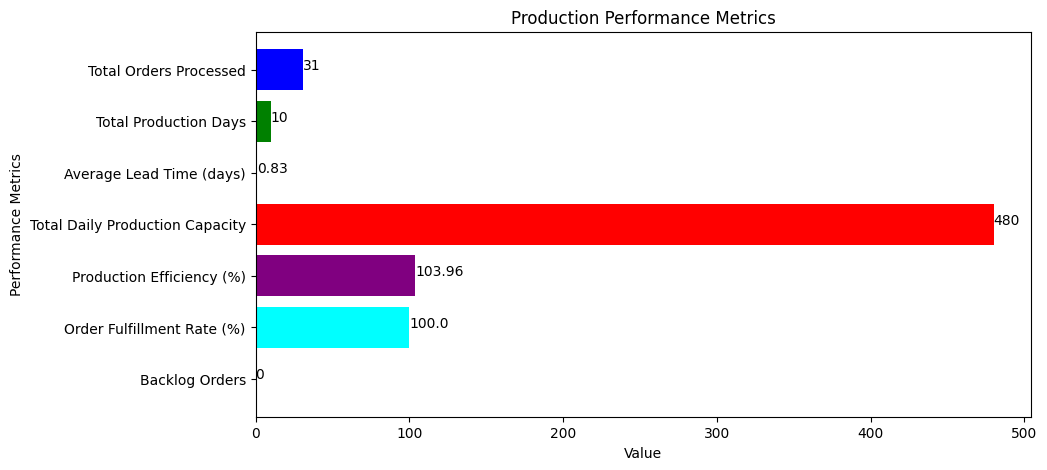

In [ ]:
import matplotlib.pyplot as plt

# Sample data for performance_metrics (replace with your actual data)
performance_metrics = {
    'Total Orders Processed': 31,
    'Total Production Days': 10,
    'Average Lead Time (days)': 0.83,
    'Total Daily Production Capacity': 480,
    'Production Efficiency (%)': 103.96,
    'Order Fulfillment Rate (%)': 100.0,
    'Backlog Orders': 0
}

# Data for plotting
metrics = list(performance_metrics.keys())
values = list(performance_metrics.values())

# Create a bar chart
plt.figure(figsize=(10,5))
plt.barh(metrics, values, color=['blue', 'green', 'orange', 'red', 'purple', 'cyan', 'magenta'])

# Add labels
plt.xlabel("Value")
plt.ylabel("Performance Metrics")
plt.title("Production Performance Metrics")

# Display values on bars
for index, value in enumerate(values):
    plt.text(value, index, str(value))

# Show plot
plt.gca().invert_yaxis()  # Invert Y-axis for better readability
plt.show()

In [ ]:
import pandas as pd
import tkinter as tk
from tkinter import filedialog, messagebox
from datetime import datetime, timedelta

# Function to calculate the production schedule (same as your provided function)
def calculate_production_schedule(order_quantity, order_date, lead_time_days):
    total_production_minutes = order_quantity * 15  # minutes per battery
    days_needed = total_production_minutes // (120 * 4 * 15)
    remaining_items = order_quantity % (120 * 4)

    production_schedule = []
    current_date = order_date

    for day in range(int(days_needed)):
        production_schedule.append({
            'Production Date': current_date.strftime('%Y-%m-%d'),
            'Quantity Line 1': 120,
            'Quantity Line 2': 120,
            'Quantity Line 3': 120,
            'Quantity Line 4': 120,
            'Minutes Used': 120 * 4 * 15
        })
        current_date += timedelta(days=1)

    if remaining_items > 0:
        quantity_per_line = [0] * 4
        for i in range(remaining_items):
            quantity_per_line[i % 4] += 1

        production_schedule.append({
            'Production Date': current_date.strftime('%Y-%m-%d'),
            'Quantity Line 1': quantity_per_line[0],
            'Quantity Line 2': quantity_per_line[1],
            'Quantity Line 3': quantity_per_line[2],
            'Quantity Line 4': quantity_per_line[3],
            'Minutes Used': remaining_items * 15
        })

    lead_time_completion_date = order_date + timedelta(days=lead_time_days)

    return production_schedule, lead_time_completion_date

# Function to load CSV and calculate production schedule
def load_and_process_files():
    # File dialog to select Orders and Inventory CSV files
    orders_file = filedialog.askopenfilename(title="Select Orders CSV", filetypes=[("CSV Files", "*.csv")])
    inventory_file = filedialog.askopenfilename(title="Select Inventory CSV", filetypes=[("CSV Files", "*.csv")])

    if not orders_file or not inventory_file:
        messagebox.showerror("Error", "Both Orders and Inventory CSV files are required!")
        return

    try:
        # Load data
        orders_df = pd.read_csv(orders_file)
        inventory_df = pd.read_csv(inventory_file)

        # Processing data
        orders_df['QUANTITY'] = pd.to_numeric(orders_df['QUANTITY'], errors='coerce')
        inventory_df['LEAD_TIME'] = pd.to_numeric(inventory_df['LEAD_TIME'], errors='coerce')
        orders_df['ORDER_DATE'] = pd.to_datetime(orders_df['ORDER_DATE'], errors='coerce')

        # Handle missing dates
        orders_df['ORDER_DATE'].fillna(orders_df['ORDER_DATE'].min(), inplace=True)

        # Merge data
        order_inventory_df = pd.merge(orders_df, inventory_df[['PRODUCT_ID', 'LEAD_TIME']], on='PRODUCT_ID', how='left')

        # Apply production scheduling for each order
        final_schedule = []
        for index, row in order_inventory_df.iterrows():
            order_quantity = row['QUANTITY']
            order_date = row['ORDER_DATE']
            lead_time_days = row['LEAD_TIME']

            schedule, lead_time_completion_date = calculate_production_schedule(order_quantity, order_date, lead_time_days)

            for entry in schedule:
                final_schedule.append({
                    'Order No': row['ORDER_ID'],
                    'Item Code': row['PRODUCT_ID'],
                    'Item Description': row['PRODUCT_NAME'],
                    'Order Quantity': row['QUANTITY'],
                    'Lead Time (days)': lead_time_days,
                    'Lead Time Completion Date': lead_time_completion_date.strftime('%Y-%m-%d'),
                    'Production Date': entry['Production Date'],
                    'Quantity Line 1': entry['Quantity Line 1'],
                    'Quantity Line 2': entry['Quantity Line 2'],
                    'Quantity Line 3': entry['Quantity Line 3'],
                    'Quantity Line 4': entry['Quantity Line 4'],
                    'Minutes Used': entry['Minutes Used']
                })

        # Convert final schedule to DataFrame
        final_schedule_df = pd.DataFrame(final_schedule)

        # Display production schedule
        display_production_schedule(final_schedule_df)
        save_schedule_to_csv(final_schedule_df)

    except Exception as e:
        messagebox.showerror("Error", f"An error occurred: {str(e)}")

# Function to display the production schedule in the application
def display_production_schedule(df):
    for widget in result_frame.winfo_children():
        widget.destroy()

    # Display DataFrame in the GUI
    for i, col in enumerate(df.columns):
        label = tk.Label(result_frame, text=col, font=("Arial", 10, 'bold'), padx=10, pady=5)
        label.grid(row=0, column=i)

    for i, row in df.iterrows():
        for j, value in enumerate(row):
            label = tk.Label(result_frame, text=value, font=("Arial", 10), padx=10, pady=5)
            label.grid(row=i+1, column=j)

# Function to save the schedule to a CSV
def save_schedule_to_csv(df):
    save_file = filedialog.asksaveasfilename(defaultextension=".csv", filetypes=[("CSV Files", "*.csv")])
    if save_file:
        df.to_csv(save_file, index=False)
        messagebox.showinfo("Success", f"Production schedule saved to {save_file}")

# Initialize the Tkinter GUI window
root = tk.Tk()
root.title("Production Schedule Generator")
root.geometry("900x600")

# Frame for the buttons and file selection
frame = tk.Frame(root)
frame.pack(pady=20)

load_button = tk.Button(frame, text="Load Orders & Inventory Files", command=load_and_process_files, font=("Arial", 12))
load_button.pack()

# Frame to display the results
result_frame = tk.Frame(root)
result_frame.pack(pady=20)

root.mainloop()


TclError: no display name and no $DISPLAY environment variable